# Thông tin nhóm 14

1612406 - Đặng Phương Nam

1612423 - Lê Minh nghĩa

# 1. Câu hỏi

Cho các thông tin về căn nhà:

- Giá cho thuê trước khi bán.
- Địa chỉ.
- Loại nhà.
- Số phòng ngủ.
- Số nhà vệ sinh.
- Diện tích phần nhà.
- Diện tích toàn bộ lô đất.
- Năm xây dựng.
- Tiền thuế.
- Gần mấy trường học.
- Tình hình tội phạm.
- ...

Hỏi giá trị của căn nhà là bao nhiêu tiền?

# 2. Lợi ích khi trả lời được câu hỏi

Nhờ vào thông tin của căn nhà:

- Người bán có thể dự đoán được giá trị căn nhà mà mình muốn bán.
- Người mua có thể ước lượng được căn nhà mình muốn mua có giá cả hợp lý hay không?.
- Dự đoán được giá trị căn nhà của mình.
- ...

# 3. Thu thập dữ liệu

## 3.1. Parse HTML

Dữ liệu thu thập từ trang web https://www.realtytrac.com/. Ta chỉ thu thập dữ liệu "các estate đã được bán tại  California", ta có HTML cần parse: https://m.realtytrac.com/mapsearch/sold/ca/

Thời gian lấy dữ liệu: Ngày 10/12/2019

In [ ]:
# Import các thư viện cần thiết.
import urllib.robotparser
import json
import os.path
import re

from requests_html import HTMLSession

In [ ]:
rp = urllib.robotparser.RobotFileParser()
rp.set_url('https://m.realtytrac.com/robots.txt')
rp.read()

In [ ]:
# Lấy link chứa danh sách các ngôi nhà đã bán theo Quận tại California
check_parse = rp.can_fetch('*', 'https://m.realtytrac.com/mapsearch/sold/ca/')

base_url = "https://m.realtytrac.com"
list_url_county = []

# Kiểm tra việc parse HTML được cho phép hay không?
if check_parse == True:
    session = HTMLSession()
    r = session.get('https://m.realtytrac.com/mapsearch/sold/ca/')

    counties = r.html.find("option")

    for county in counties:
        tail_url = county.attrs['value']
        if (tail_url):
            url = base_url + tail_url
            list_url_county.append(url)


list_url_county

In [ ]:
# Hàm trả về generator, generator này trả về trang tiếp theo sau mỗi lần duyệt.
def urlGenerator(baseUrl, startPage=1):
    i = startPage
    if i <= 1:
        yield baseUrl
        i = 2
    while True:
        yield f"{baseUrl}/p-{i}"
        i += 1


# Hàm parseDetailPage: parse để lấy thông tin chi tiết của từng căn nhà từ detailUrl (của căn nhà đã bán).
# Tham số: session và detailUrl của căn nhà cần parse.
# Trả về: dictionary chứa các thông tin đã parse được.
def parseDetailPage(session: HTMLSession, detailUrl: str):

    # Lấy mã HTML của trang web.
    r = session.get(detailUrl)

    # Dictionary lưu lại kết quả.
    result = {}

    # Lấy address của estate.
    address = {}
    street = r.html.find("[itemprop = 'streetAddress']", first=True)
    if street is not None:
        street = street.text

    locality = r.html.find("[itemprop = 'addressLocality']", first=True)
    if locality is not None:
        locality = locality.text

    region = r.html.find("[itemprop = 'addressRegion']", first=True)
    if region is not None:
        region = region.text

    code = r.html.find("[itemprop = 'postalCode']", first=True)
    if code is not None:
        code = code.text

    address["street"] = street
    address["locality"] = locality
    address["region"] = region
    address["code"] = code

    result["address"] = address

    # Lấy thông tin ngày đã bán căn nhà.
    date_sold = r.html.find(".recently-sold", first=True)
    if date_sold is not None:
        result["date_sold"] = date_sold.text.replace("SOLD ON ", "")
    else:
        result["date_sold"] = None

    # Lấy giá cho thuê trước khi bán.
    mortgage = r.html.find(".property-price-info", first=True)
    if mortgage is not None:
        result["mortgage"] = mortgage.text.replace("Est. Mortgage: ","")
    else:
        result["mortgage"] = None


    # Lấy phân mô tả chi tiết về căn nhà.
    details = []
    detailTexts = r.html.find(".detail-text")
    if detailTexts is not None:
        for detailText in detailTexts:
            details.append(detailText.html)  # sở dĩ lấy mà HTML để dễ parse sau này (khi muốn lấy thông tin từ details)
    result["details"] = details

    # Lấy property info của căn nhà.
    propertyInfo = r.html.find(".property-info", first=True)
    if propertyInfo is not None:
        info = {}
        items = propertyInfo.find(".item")
        if items is not None:
            for item in items:
                name = item.find(".name", first=True).text.lower().replace(" ", "_")
                value = item.find(".value", first=True).text
                info[name] = value

        result["info"] = info
    else:
        result["info"] = None

    # Lấy property taxes của căn nhà.
    property_taxes = r.html.find(".property-taxes")
    if property_taxes is not None:
        for tax in property_taxes:
            key = tax.find(".section-head", first=True).text.lower().replace(" ", "_")
            taxes = {}
            items = tax.find(".item")
            if items is not None:
                for item in items:
                    name = item.find(".name", first=True).text.lower().replace(" ", "_")
                    value = item.find(".value", first=True).text
                    taxes[name] = value

            result[key] = taxes

    # Lấy số lượng trường học gần đó.
    local_school = r.html.find(".property-schools", first=True)
    num_school = 0
    if local_school is not None:
        num_school = len(local_school.find(".schoolInfo"))

    result["school"] = num_school

    # Lấy thông tin tội phạm trong vùng.
    crimes = {}
    local_crime_index = r.html.find(".property-local-crime", first=True)
    if local_crime_index is not None:
        type_crimes = local_crime_index.find(".gradeTitle")
        if type_crimes is not None:
            for type_crime in type_crimes:
                match = re.match(r"(.+?) = (\d+)", type_crime.text)
                if match is not None:
                    key = match.group(1).lower().replace(' ', '_')
                    value = int(match.group(2))
                    crimes[key] = value

    result["local_crime_index"] = crimes

    # Lấy số lượng nhà bị tịch thu gần đó.
    nearby_foreclosures = r.html.find(".property-nearby-fc", first=True)
    num_fc = 0
    if nearby_foreclosures is not None:
        num_fc = len(nearby_foreclosures.find(".nearby-property"))

    result["foreclosures"] = num_fc

    return result

In [ ]:
# Hàm parseSearchPage: parse theo page (mỗi parse chứa danh sách và url của 25 căn nhà đã được bán).
# Tham số: session và url của page hiện tại.
# Trả về: list thông tin chi tiết của tất cả căn nhà tại page hiện tại và url của page kế tiếp.
def parseSearchPage(session: HTMLSession, urlPage: str):

    # Lấy mã HTML.
    r = session.get(urlPage)

    # Lấu detailUrl của tất cả bất động sản.
    detailUrls = [link for link in r.html.absolute_links if 'property' in link]

    results = []  # List chứa kết quả parse được tại page.

    # Tiến hành parse từ detailUrl
    for detailUrl in detailUrls:
        # Kiểm tra việc parse HTML được cho phép hay không?
        if not rp.can_fetch('*', detailUrl):
            print(f"SKIP: {detailUrl}")
            continue

        print(f"Parsing detail url {detailUrl}")
        result = parseDetailPage(session, detailUrl)
        results.append(result)

    nextPageAnchor = r.html.find(".current + .page", first=True)
    return results, nextPageAnchor is not None

In [ ]:
# Hàm getAllCountyProperties: parse tất cả các page của một County để lấy thông tin chi tiết của 
# căn nhà được bán thành công.
# Tham số: session và countryUrl chứa thông tin các căn nhà được bán của một County.
# Trả về: File chứa kết quả đã parse thành công (tên file là tên County được parse).
def getAllCountyProperties(session: HTMLSession, countyUrl: str):
    # Lấy tên County từ urlCounty.
    if countyUrl.endswith("/"):
        countyUrl = countyUrl[:-1]
    fileName = f"data/{os.path.basename(countyUrl)}.json"

    # Kiểm tra sự tồn tại file.
    if os.path.exists(fileName):
        print(f"FILE EXISTS: {fileName}")
        return

    # Mở file để ghi dữ liệu (kiểu file là json)
    with open(fileName, "a") as fOut:
        for url in urlGenerator(countyUrl, 1):
            # Kiểm tra việc parse HTML được cho phép hay không?
            if not rp.can_fetch('*', url):
                print(f"SKIP: {url}")
                continue

            # Tiến hành parse theo từng page.
            print(f"Parsing {url}")
            results, nextPage = parseSearchPage(session, url)

            # Ghi kết quả xuống file.
            for result in results:
                json.dump(result, fOut, ensure_ascii=False)
                fOut.write("\n")

            # Kiểm tra có còn page tiếp theo hay không?
            if not nextPage:
                break

            # Mỗi lần parse 1 page thì cho sleep 2s.
            time.sleep(2)

Tiến hành lấy dữ liệu. Lưu ý trong quá trình lấy có thể bị timeout do đường truyền mạng, nếu bị thì chỉ cần làm theo các bước sau:
- Xem đã lấy tới page mấy. vd: "...page-125"
- Đổi lại tên file trong thư mục data là "orange-county-1.json" chẳng hạn (số 1, 2, 3,.. là theo mỗi lần lấy dữ liệu của mình).
- Vào hàm "getAllCountyProperties" đổi lại dòng "for url in urlGenerator(countyUrl, 1)" thành "for url in urlGenerator(countyUrl, 125)", số 125 là tùy mình lấy tới page thứ mấy mà bị timeout.
- Dữ liệu tất nhiên sẽ bi trùng, cứ việc yên tâm vì phần sau sẽ xóa trung.

In [ ]:
url = "https://m.realtytrac.com/mapsearch/sold/ca/orange-county"
session = HTMLSession()
getAllCountyProperties(session, url)

In [ ]:
# Phần gộp từng phần dữ liệu đã lấy dang dở lại thành 1 file.
# Nếu không bị timeout như trường hợp ở trên thì không dùng shell code này.
inputFiles = ["data/orange-county-1.json", "data/orange-county-2.json", 
              "data/orange-county-3.json", "data/orange-county-4.json"]
outputFile = "data/full-orange-county.json"

with open(outputFile, "a+") as fOut:
    for inputFile in inputFiles:
        with open(inputFile, "r") as fIn:
            data = fIn.read()
            fOut.write(data)

In [ ]:
# Phần convert file json sang file csv.

def xstr(s):
    return '' if s is None else str(s)


# Hàm preprocessFile: chuyển file json sang file csv.
# Tham số: tên file json và tên file csv.
# Không trả về.
def preprocessFile(inputFile: str, outputFile: str):

    # Kiểm tra tồn tại file Input.
    if os.path.exists(outputFile):
        print(f"FILE EXISTS: {outputFile}")
        return

    # Kiểm tra tồn tại file Output.
    if not os.path.exists(inputFile):
        print(f"Input file not found: {inputFile}")
        return

    with open(inputFile) as fIn, open(outputFile, "w") as fOut:
        tab = "\t"
        headers = (
            "address_street",
            "address_locality",
            "address_region",
            "address_code",
            "date_sold",
            "mortgage",
            "info_type",
            "info_bedrooms",
            "info_bathrooms",
            "info_size",
            "info_lot_size",
            "info_year_built",
            "info_est_value",
            "info_sold_price",
            "info_property_id",
            "info_county",
            "info_parcel_number",
            "taxes_land",
            "taxes_improvements",
            "taxes_total",
            "taxes_taxes",
            "school",
            "total_crime",
            "violent_crime",
            "property_crime",
            "foreclosures",
        )

        # Ghi các tên cột vào file output, mỗi cột ngăn cách bởi "\t".
        fOut.write(f"{tab.join(headers)}\n")

        # Duyệt từng line trong file Input (json).
        for line in fIn:
            row = json.loads(line)

            # Lấy địa chỉ
            address = row.get("address")
            address_street = address.get("street")
            address_locality = address.get("locality")
            address_region = address.get("region")
            address_code = address.get("code")

            # Lấy ngày bán thành công.
            date_sold = row.get("date_sold")

            # Lấy giá cho thuê mỗi tháng (trước khi được bán).
            mortgage = row.get("mortgage")
            if mortgage is not None:
                mortgage = float(mortgage.replace("$","").replace(",","").replace("/mo","").replace("Est. Refinance: ", ""))

            # Lấy phần info
            info = row.get("info")

            # Type.
            info_type = info.get("type")

            # Bedrooms.
            info_bedrooms = info.get("bedrooms")
            if info_bedrooms == "Contact Agent":
                info_bedrooms = None
            else:
                info_bedrooms = float(info_bedrooms)

            # Bathrooms.
            info_bathrooms = info.get("bathrooms")
            if info_bathrooms == "Contact Agent":
                info_bathrooms = None
            else:
                info_bathrooms = float(info_bathrooms)

            # Size.
            info_size = info.get("size")
            if info_size == "Contact Agent":
                info_size = None
            else:
                info_size = float(info_size.replace(",", "").replace(" sqft", ""))

            # Lot size.
            info_lot_size = info.get("lot_size")
            if info_lot_size == "Contact Agent":
                info_lot_size = None
            else:
                info_lot_size = float(info_lot_size.replace(",", "").replace(" sqft", "").replace(" acres", ""))

            # Year build.
            info_year_built = info.get("year_built")
            if info_year_built  == "Contact Agent":
                info_year_built = None
            else:
                info_year_built = int(info_year_built)

            # Est value.
            info_est_value = info.get("est._value")
            if info_est_value is not None:
                info_est_value = float(info_est_value.replace("$", "").replace(",",""))

            # Sold price.
            info_sold_price = info.get("sold_price")
            if info_sold_price is not None:
                if info_sold_price != "N/A":
                    info_sold_price = float(info_sold_price.replace("$", "").replace(",", ""))

            # ID.
            info_property_id = info.get("property_id")

            # County.
            info_county = info.get("county")

            # Parcel_number.
            info_parcel_number = info.get("parcel_number")

            # Lấy phần Taxes.
            taxes = row.get("property_taxes")
            taxes_land = None
            taxes_improvements = None
            taxes_total = None
            taxes_taxes = None
            if taxes is not None:
                taxes_land = float(taxes.get("land").replace("$", "").replace(",", ""))
                taxes_improvements = float(taxes.get("improvements").replace("$", "").replace(",", ""))
                taxes_total = float(taxes.get("total").replace("$", "").replace(",", ""))
                taxes_taxes = taxes.get("taxes").replace("$", "").replace(",", "")

            # Lấy số lượng scholl gần đó.
            school = int(row.get("school"))

            # Lấy tình hình tội phạm.
            crime = row.get("local_crime_index")
            if crime is not None:
                total_crime = crime.get("total_crime")
                if total_crime is not None:
                    total_crime = int(total_crime)
                violent_crime = crime.get("violent_crime")
                if violent_crime is not None:
                    violent_crime = int(violent_crime)
                property_crime = crime.get("property_crime")
                if property_crime is not None:
                    property_crime = int(property_crime)

            # Lấy số lượng foreclosures gần đó.
            foreclosures = int(row.get("foreclosures"))

            # Row này là tổng hợp các thông tin lấy được ở trên.
            row = (
                xstr(address_street),
                xstr(address_locality),
                xstr(address_region),
                xstr(address_code),
                xstr(date_sold),
                xstr(mortgage),
                xstr(info_type),
                xstr(info_bedrooms),
                xstr(info_bathrooms),
                xstr(info_size),
                xstr(info_lot_size),
                xstr(info_year_built),
                xstr(info_est_value),
                xstr(info_sold_price),
                xstr(info_property_id),
                xstr(info_county),
                xstr(info_parcel_number),
                xstr(taxes_land),
                xstr(taxes_improvements),
                xstr(taxes_total),
                xstr(taxes_taxes),
                xstr(school),
                xstr(total_crime),
                xstr(violent_crime),
                xstr(property_crime),
                xstr(foreclosures),
            )

            # Ghi xuống file output
            fOut.write(f"{tab.join(row)}\n")

&#9889; Sở dĩ nhóm không thêm phần `description` vào dữ liệu là bởi vì khi quan sát phần mã `html` của `description` thì phát hiện ra nó được viết theo một `format` nhất định, các thông tin số liệu của nó được lấy từ các bảng số liệu trong cùng một trang web (tức là các phần thông tin nhà, thuế,.. mà mình đã parse ở trên). Nếu số liệu nào có thì sẽ được lấy ra và tạo một câu mô tả theo `format` cho trước, còn số liệu nào không có thì hiển nhiên không xuất hiện câu đó. Như vậy, có thể kết luận là phần `description` lúc này sẽ không giúp ích gì cho chúng ta.

In [ ]:
inputFile = "data/full-orange-county.json"
outputFile = "data/orange-county.csv"
preprocessFile(inputFile, outputFile)

## 3.2. Lựa chọn dữ liệu của năm 2019 và có "correct ouput"

In [ ]:
# Import các thư viện cần thiết.
import pandas as pd

### 3.2.1 Xóa dữ liệu trùng

#### Dữ liệu ban đầu

In [ ]:
# Đọc dữ liệu lên
file_csv = "data/Orange-County/orange-county.csv"
data_df =  pd.read_csv(file_csv, sep='\t')
data_df.head(10)

In [ ]:
data_df.info()

Dữ liệu ban đầu có 21268 dòng.

#### Dữ liệu sau khi xóa trùng

In [ ]:
# Xóa các phần dữ liệu bị trùng
unique_data_df = data_df.drop_duplicates()

In [ ]:
# Xem phần dữ liệu khi đã xóa trùng
unique_data_df.info()

Dữ liệu sau khi xóa trùng còn lại 18893 dòng.

In [ ]:
# Ghi dữ liệu xuống file csv
unique_data_df.to_csv("data/Orange-County/delete-duplicate-orange.csv", sep='\t', index=False)

### 3.2.2. Lấy dữ liệu của năm 2019

In [ ]:
# Đọc dữ liệu lên
df = pd.read_csv("data/Orange-County/delete-duplicate-orange.csv", sep='\t')
df.head(10)

In [ ]:
df.info()

In [ ]:
# Thêm cột năm bán vào dữ liệu
df = df.assign(year_sold=df.date_sold.str[-4:])

In [ ]:
# Xem dữ liệu này thu thập của các năm nào
df.year_sold.unique()

In [ ]:
# Chỉ lấy phần dữ liệu của năm 2019
df = df[df.year_sold == "2019"]
df.year_sold = df.year_sold.astype(int)

In [ ]:
# Ghi dữ liệu xuống file csv
df.to_csv("data/Orange-County/delete-duplicate-orange-2019.csv", sep='\t', index=False)

### 3.2.3. Lấy dữ liệu của năm 2019 có "correct output"

In [ ]:
import pandas as pd

In [ ]:
# Đọc dữ liệu
data_df = pd.read_csv("data/Orange-County/delete-duplicate-orange-2019.csv", sep='\t')
data_df.head(10)

In [ ]:
data_df.info()

Dữ liệu có 16011 căn nhà được bán trong 2019

Ta chỉ lấy dữ liệu có `info_sold_price` khác `null`. Như đã nói ở phần cuối của `1.1. Parse HTML` thì không thể tìm kiếm các giá trị chính xác từ phần `decription` để có thể lắp đầy giá trị `null`, mà nếu có tìm cũng chỉ toàn ra giá trị trung bình của các căn nhà được bán lân cận chứ không phải giá trị chính xác của nó.

In [ ]:
df = data_df[pd.notna(data_df["info_sold_price"])]

In [ ]:
df.info()

Dữ liệu còn lại là 15755.

&#9889; Sau khi xóa các dòng có sold_price là `null`. Xem lại cột `info_est_value` thấy toàn `null`, cột này ý nghĩa là giá trị định giá của căn nhà trên các bản rao bán (chưa chốt giá). Nên xóa đi cột này là hoàn toàn hợp lý.

In [ ]:
df = df.drop(columns=["info_est_value"])
df.info()

Ta cần kiểm tra xem ứng với `15755` dòng dữ liệu thì phải có đúng `15755` `info_property_id` hay không?

In [ ]:
len(df.info_property_id.unique())

OK ổn vì có đúng `15755` `info_property_id` như mong muốn

Bây giờ, ta kiểm tra liệu ứng với mỗi `address_street` liệu chỉ có duy nhất một căn nhà được bán thành công hay không?

In [ ]:
address_street_count = df.address_street.value_counts()
address_street_count

Như vậy có `38` `address_street` có số lượng nhà bán thành công trong năm 2019 lơn hơn 1, trong đó lại có `1600 S Disneyland Dr` có số lần xuất hiện lên đến con sô `16`, điều này hơi kỳ lạ. Vì vậy, ta cần quan sát thêm về các `addresss_street` kiểu này.

In [ ]:
# Lấy tên các addresss_street có số lượng nhà được bán trong năm 2019 nhiều hơn 1
duplicate_addresss_street = address_street_count[address_street_count > 1].index
duplicate_addresss_street

In [ ]:
len(duplicate_addresss_street)

Xem thử tất cả các dòng có `address_street` là `1600 S Disneyland Dr` (hay `duplicate_addresss_street[0]`)

In [ ]:
tmp_df = df[df.address_street == duplicate_addresss_street[0]]
tmp_df

In [ ]:
tmp_df.info_sold_price

Đối với những dòng có cùng `address_street` mà lại khác `date_sold` và `info_sold_price` thì nên bỏ là hợp lý và khó có thể lấy được chính xác giá trị `sold_price`.

Tiếp tục, xem thử tất cả các dòng có `address_street` là `200 W Midway Dr ` (hay `duplicate_addresss_street[1]`)

In [ ]:
tmp_df = df[df.address_street == duplicate_addresss_street[1]]
tmp_df

In [ ]:
tmp_df.info_sold_price

Mặc dù có cùng `address_street`, cùng `date_sold` và cùng `info_sold_price` nhưng lại có các giá trị `taxes` thay đổi một cách kỳ lại + với các thông tin chính (`info_bedrooms`, `info_bathroooms`,...) bị thiếu. Phần các thông tin chính này có thể giải quyết bằng `fill miss value` (`mean`, `median`, `most`,...) nhưng phần `taxes` thì nhóm không biết xác định như thế nào cho hợp lý và gần chính xác nhất. Nên quyết định bỏ luôn các dòng dạng này.

In [ ]:
sum(address_street_count[address_street_count > 1])

Có `106` dòng dữ liệu bị như thế, so với `15755` dòng dữ liệu hiện có thì chúng chưa chiếm đến `1%` nên nhóm quyết định bỏ đi là hợp lý.

In [ ]:
df = df[~df.address_street.isin(duplicate_addresss_street)]
df.info()

In [ ]:
# Ghi dữ liệu xuống file csv.
df.to_csv("data/Orange-County/data-2019.csv", sep='\t', index=False)

#### Tách dữ liệu thành 2 tập train và test theo tỉ lệ 80% 20%

In [ ]:
# Đọc dữ liệu lên
data_df = pd.read_csv("data/Orange-County/data-2019.csv", sep='\t')
data_df.head()

In [ ]:
data_df.info()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Đổi tên
data_df = data_df.rename(columns={"info_sold_price": "sold_price"})

In [ ]:
# Tách dữ liệu theo tỉ lệ 80% và 20%
train, test = train_test_split(data_df, test_size=0.2, random_state=0)
train.head().index

&#9889; Nhóm đã cố định `random_state` trong `train_test_split` để đảm bảo kết quả của thầy ra giống với của nhóm. Kết quả của câu lệnh `train.head().index` của nhóm ra 5 giá trị là: [2746, 8859, 11288, 2153, 12119]. 

In [ ]:
# Ghi tập train
train.to_csv("data/Orange-County/train-data-2019.csv", sep='\t', index=False)

In [ ]:
# Ghi tập test
test.to_csv("data/Orange-County/test-data-2019.csv", sep='\t', index=False)

# 4. Tiền xử lý dữ liệu

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
data_df = pd.read_csv("data/Orange-County/train-data-2019.csv", sep='\t')
data_df.head()

,address_street,address_locality,address_region,address_code,date_sold,mortgage,info_type,info_bedrooms,info_bathrooms,info_size,...,taxes_land,taxes_improvements,taxes_total,taxes_taxes,school,total_crime,violent_crime,property_crime,foreclosures,year_sold
0,13242 Amarillo Dr,Westminster,CA,92683,10/24/2019,3157.0,Single Family Residence,3.0,1.0,1090.0,...,508260.0,54780.0,563040.0,6969 (1.23 %),3,97.0,79.0,140.0,4,2019
1,716 S Palomino Ln,Anaheim,CA,92807,08/16/2019,2748.0,Single Family Residence,3.0,3.0,1582.0,...,371674.0,148526.0,520200.0,5527 (1.06 %),3,88.0,71.0,127.0,4,2019
2,19702 Lancewood Plz,Yorba Linda,CA,92886,07/23/2019,2966.0,Single Family Residence,4.0,2.0,1440.0,...,29459.0,43373.0,72832.0,1240 (1.70 %),3,22.0,12.0,44.0,4,2019
3,25885 Trabuco Rd Apt 59,Lake Forest,CA,92630,10/30/2019,1726.0,Condominium,2.0,2.0,1190.0,...,112879.0,93656.0,206535.0,2096 (1.01 %),3,29.0,23.0,42.0,4,2019
4,6742 Gate Hill Cir,Huntington Beach,CA,92648,07/15/2019,5860.0,Single Family Residence,4.0,3.0,2193.0,...,159764.0,148957.0,308721.0,3706 (1.20 %),3,57.0,47.0,82.0,4,2019


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12519 entries, 0 to 12518
Data columns (total 26 columns):
address_street        12485 non-null object
address_locality      12519 non-null object
address_region        12519 non-null object
address_code          12519 non-null int64
date_sold             12519 non-null object
mortgage              12519 non-null float64
info_type             12519 non-null object
info_bedrooms         11363 non-null float64
info_bathrooms        11371 non-null float64
info_size             11946 non-null float64
info_lot_size         8484 non-null float64
info_year_built       11571 non-null float64
sold_price            12519 non-null float64
info_property_id      12519 non-null int64
info_county           12519 non-null object
info_parcel_number    12519 non-null int64
taxes_land            12321 non-null float64
taxes_improvements    12321 non-null float64
taxes_total           12321 non-null float64
taxes_taxes           12321 non-null object
schoo

Tập train có `12519` dòng dữ liệu và `26` cột.

In [4]:
data_df.describe(include="all")

,address_street,address_locality,address_region,address_code,date_sold,mortgage,info_type,info_bedrooms,info_bathrooms,info_size,...,taxes_land,taxes_improvements,taxes_total,taxes_taxes,school,total_crime,violent_crime,property_crime,foreclosures,year_sold
count,12485,12519,12519,12519.000000,12519,1.251900e+04,12519,11363.000000,11371.000000,11946.000000,...,1.232100e+04,1.232100e+04,1.232100e+04,12321,12519.000000,12156.000000,12156.000000,12156.000000,12519.000000,12519.0
unique,12485,52,2,NaN,155,NaN,14,NaN,NaN,NaN,...,NaN,NaN,NaN,11959,NaN,NaN,NaN,NaN,NaN,NaN
top,14 Curacao,Irvine,CA,NaN,06/28/2019,NaN,Single Family Residence,NaN,NaN,NaN,...,NaN,NaN,NaN,10555 (1.12 %),NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1107,12517,NaN,232,NaN,8162,NaN,NaN,NaN,...,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,92552.015816,NaN,8.928697e+03,NaN,3.124263,2.602102,2426.583208,...,5.009780e+05,2.826592e+05,7.836531e+05,NaN,2.884016,54.516946,42.570171,82.203274,3.853822,2019.0
std,NaN,NaN,NaN,564.557227,NaN,7.526277e+04,NaN,1.008088,0.991297,7797.643516,...,1.434805e+06,1.751883e+06,2.832966e+06,NaN,0.578382,29.778698,28.960716,37.985382,0.750273,0.0
min,NaN,NaN,NaN,90620.000000,NaN,2.000000e+00,NaN,1.000000,1.000000,301.000000,...,4.410000e+02,0.000000e+00,0.000000e+00,NaN,0.000000,13.000000,1.000000,23.000000,0.000000,2019.0
25%,NaN,NaN,NaN,92630.000000,NaN,2.548000e+03,NaN,2.000000,2.000000,1264.000000,...,1.504430e+05,7.841300e+04,2.769060e+05,NaN,3.000000,29.000000,22.000000,48.000000,4.000000,2019.0
50%,NaN,NaN,NaN,92677.000000,NaN,3.339000e+03,NaN,3.000000,3.000000,1671.000000,...,3.111640e+05,1.312930e+05,4.712400e+05,NaN,3.000000,55.000000,39.000000,82.000000,4.000000,2019.0
75%,NaN,NaN,NaN,92804.000000,NaN,4.610000e+03,NaN,4.000000,3.000000,2377.750000,...,5.119080e+05,2.319820e+05,7.320000e+05,NaN,3.000000,71.000000,54.000000,122.000000,4.000000,2019.0


## 4.1. Tách tập dữ liệu thành 2 phần train (70%) và validation (30%)

In [5]:
# Tách X và y
y_sr = data_df["sold_price"] # sr là viết tắt của series
X_df = data_df.drop("sold_price", axis=1)

In [6]:
# Tách tập train và tập validation theo tỉ lệ 70%:30%
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.3, random_state=0)
train_X_df.head().index

Int64Index([10747, 12214, 5916, 489, 12257], dtype='int64')

&#9889; Nhóm đã cố định `random_state` trong `train_test_split` để đảm bảo kết quả của thầy ra giống với của nhóm. Kết quả của câu lệnh `train_X_df.head().index` của nhóm ra 5 giá trị là: [10747, 12214, 5916, 489, 12257]. 

In [7]:
train_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8763 entries, 10747 to 2732
Data columns (total 25 columns):
address_street        8736 non-null object
address_locality      8763 non-null object
address_region        8763 non-null object
address_code          8763 non-null int64
date_sold             8763 non-null object
mortgage              8763 non-null float64
info_type             8763 non-null object
info_bedrooms         7951 non-null float64
info_bathrooms        7956 non-null float64
info_size             8361 non-null float64
info_lot_size         5931 non-null float64
info_year_built       8099 non-null float64
info_property_id      8763 non-null int64
info_county           8763 non-null object
info_parcel_number    8763 non-null int64
taxes_land            8632 non-null float64
taxes_improvements    8632 non-null float64
taxes_total           8632 non-null float64
taxes_taxes           8632 non-null object
school                8763 non-null int64
total_crime           84

`train_X_df` có `8763` dòng dữ liệu và `25` cột.

In [8]:
val_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3756 entries, 1540 to 4911
Data columns (total 25 columns):
address_street        3749 non-null object
address_locality      3756 non-null object
address_region        3756 non-null object
address_code          3756 non-null int64
date_sold             3756 non-null object
mortgage              3756 non-null float64
info_type             3756 non-null object
info_bedrooms         3412 non-null float64
info_bathrooms        3415 non-null float64
info_size             3585 non-null float64
info_lot_size         2553 non-null float64
info_year_built       3472 non-null float64
info_property_id      3756 non-null int64
info_county           3756 non-null object
info_parcel_number    3756 non-null int64
taxes_land            3689 non-null float64
taxes_improvements    3689 non-null float64
taxes_total           3689 non-null float64
taxes_taxes           3689 non-null object
school                3756 non-null int64
total_crime           365

`val_X_df` có `3756` dòng dữ liệu và `25` cột.

## 4.2. Quan sát và lựa chọn dữ liệu bằng kiến thức cá nhân trên tập train (`train_X_df` và `train_y_sr`)

### 4.2.1. Quan sát cột `address_street`

In [9]:
# https://stackoverflow.com/questions/55105280/how-to-extract-apartment-from-address-in-pandas
pat = r'^(?P<number>\d+)?(?P<direction>.\w(?= ))?(?P<street>.+(?=\bapt|\bunit)|.+(?=#)|.+)(?P<apt_unit>(?:\bapt|\bunit|#|).+)?'
lower_address_street = train_X_df.address_street.str.lower()
tmp = lower_address_street.str.extract(pat)
tmp

,number,direction,street,apt_unit
10747,6891,NaN,lawn haven dr,NaN
12214,422,NaN,larkspur ave,NaN
5916,183,NaN,luneta ln,NaN
489,16,NaN,kingfisher ct,NaN
12257,14391,NaN,flower st,NaN
5010,11721,NaN,pine st,NaN
2271,98,NaN,ashdale,NaN
11574,402,w,linden dr,NaN
6780,6991,NaN,san pedro cir,NaN
12148,543,NaN,avenida del verdor,NaN


In [10]:
tmp["street"].value_counts()

 macarthur blvd       16
 cabrillo park dr     15
 cerritos ave         14
 via mariposa w       14
 brookhurst st        14
 lambert rd           13
 el toro rd           12
 orange ave           12
 broadway             12
 harbor blvd          11
 via puerta           11
 oceanfront           10
 viejo hills dr       10
 le parc               9
 chapman ave           9
 olive st              9
 montecito rd          9
 flower st             9
 walnut ave            9
 san amadeo            9
 acacia ave            8
 sycamore ave          8
 alienta ln            8
 martin                8
 western ave           8
 walnut st             8
 garner way            8
 mitchell ave          8
 coast hwy             8
 1st st                8
                      ..
 balboa ave            1
 blandings             1
 baronet               1
 webster st            1
 thurin st             1
 lake hill dr          1
 tarocco               1
 oxford ave            1
 reston way            1


In [11]:
sum(tmp["street"].value_counts() > 1)

1504

In [12]:
len(tmp["street"].unique())

6051

Theo kết quả tìm kiếm trên internet (https://cartographic.info/usa/street/show.php?p=california&t=Orange%20County) thì có `280` tên đường lớn tại `Orange County`. Vậy trong danh sách mà nhóm parse được có đến `6051` tên đường khác nhau, chắc bao gồm những con đường nhỏ. Việc dùng `street` cho huấn luyện mô hình sẽ không hiệu quả, vì khi đưa vào mô hình bằng phương pháp one-hot chắc chắn sẽ tạo ra số chiều rất lớn và với một số địa chỉ xuất hiện rất ít dễ dẫn đén overfitting.

In [14]:
len(tmp[pd.notna(tmp["apt_unit"])])

1478

Nhóm sẽ xóa cột `address_street` và thêm cột `apt_unit` được rút trích ở trên vào dữ liệu ở bước tiền xử lý dữ liệu, cột này chỉ có 2 giá trị (`True`/`False`)

### 4.2.2. Quan sát các cột `address_locality`, `address_region` và `address_code`

&#9889; Theo tìm hiểu của nhóm, `address_code` là tổng hợp từ `address_locality` và `address_region`

In [15]:
unique_code = train_X_df.address_code.unique()
len(unique_code)

87

In [16]:
for code in unique_code:
    tmp_df = train_X_df[train_X_df.address_code == code]
    print("Code: " + str(code))
    print("\n + Locality: " + str(tmp_df.address_locality.unique()))
    print("\n + Region: " + str(tmp_df.address_region.unique()))
    print("\n")

Code: 92648

 + Locality: ['Huntington Beach']

 + Region: ['CA']


Code: 92625

 + Locality: ['Corona Del Mar' 'Corona Dl Mar']

 + Region: ['CA']


Code: 92694

 + Locality: ['Rancho Mission Viejo' 'Mission Viejo' 'Ladera Ranch']

 + Region: ['CA']


Code: 92679

 + Locality: ['Trabuco Canyon' 'Coto De Caza' 'Dove Canyon' 'Portola Hills'
 'Lake Forest']

 + Region: ['CA']


Code: 92843

 + Locality: ['Garden Grove']

 + Region: ['CA']


Code: 90720

 + Locality: ['Los Alamitos' 'Cypress']

 + Region: ['CA']


Code: 92620

 + Locality: ['Irvine']

 + Region: ['CA']


Code: 92865

 + Locality: ['Orange']

 + Region: ['CA']


Code: 90620

 + Locality: ['Buena Park']

 + Region: ['CA']


Code: 92672

 + Locality: ['San Clemente']

 + Region: ['CA']


Code: 92840

 + Locality: ['Garden Grove']

 + Region: ['CA']


Code: 90630

 + Locality: ['Cypress']

 + Region: ['CA']


Code: 92683

 + Locality: ['Westminster']

 + Region: ['CA']


Code: 92844

 + Locality: ['Garden Grove']

 + Region: 

Theo nhóm tìm hiểu thì mã `code` (`address_code`) kia là mã bưu điện, mã này có thể dùng cho nhiều `locality` ở gần nhau, do đó ta kết quả như ở trên là hoàn toàn bình thường. Giờ nhóm quyết định bỏ 2 cột `address_locality` và `addres_region`, chỉ giữ lại cột `address_code` là đủ.

2. Xem thử cột `address_code` có bao nhiêu giá trị thiếu

In [ ]:
num_miss_code = train_X_df.shape[0] - len(train_X_df[pd.notna(train_X_df.address_code)])
print("The number of missing values (column 'address_code'): " + str(num_miss_code))

Good. Cột `address_code` không có giá trị thiếu.

### 4.2.3. Quan sát cột `date_sold`

Đây là cột dạng chuỗi có giá trị rời rạc không thứ tự (categorical)

1. Xem thử cột `date_sold` có bao nhiêu giá trị thiếu

In [17]:
num_miss_date_sold = train_X_df.shape[0] - len(train_X_df[pd.notna(train_X_df.date_sold)])
print("The number of missing values (column 'date_sold'): " + str(num_miss_date_sold))

The number of missing values (column 'date_sold'): 0


Good. Cột `date_sold` không có giá trị thiếu.

2. Rút trích thông tin từ cột `date_sold`

In [18]:
train_X_df.date_sold.unique()

array(['09/11/2019', '08/23/2019', '07/29/2019', '08/22/2019',
       '07/25/2019', '06/13/2019', '11/20/2019', '06/20/2019',
       '08/06/2019', '06/10/2019', '06/17/2019', '07/12/2019',
       '08/01/2019', '11/07/2019', '07/03/2019', '09/23/2019',
       '10/08/2019', '08/19/2019', '08/09/2019', '06/27/2019',
       '06/28/2019', '11/19/2019', '10/24/2019', '06/11/2019',
       '09/12/2019', '08/20/2019', '10/17/2019', '09/25/2019',
       '11/01/2019', '11/14/2019', '08/16/2019', '09/17/2019',
       '08/15/2019', '07/26/2019', '07/05/2019', '07/08/2019',
       '09/24/2019', '07/18/2019', '09/13/2019', '08/30/2019',
       '09/20/2019', '08/26/2019', '10/11/2019', '02/04/2019',
       '07/31/2019', '06/18/2019', '06/24/2019', '11/06/2019',
       '10/09/2019', '09/26/2019', '06/14/2019', '10/16/2019',
       '09/09/2019', '10/07/2019', '07/19/2019', '07/09/2019',
       '11/15/2019', '07/15/2019', '06/26/2019', '08/14/2019',
       '09/30/2019', '09/06/2019', '10/03/2019', '10/25

Cột `date_sold` được ghi dưới dạng `MM/DD/YYYY`. Giờ nhóm sẽ rút trích `Month` từ `date_sold`.

In [19]:
month = train_X_df.date_sold.str[:2].astype(int)
sorted(month.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Sở dĩ không có tháng `12` là do thời gian lấy dữ liệu của nhóm là đầu tháng `12` nên trang web chưa cập nhật. Về sau ở bước `Xây dựng pipline tiền xử lý dữ liệu`, nhóm sẽ tiến hành xóa cột `date_sold`, thêm cột `Month` và muốn thử để nguyên `11` tháng huấn luyện tốt hơn hay chia ra thành `4` mùa tốt hơn bằng cách đặt thêm cờ hiệu `month_to_seasion`.

### 4.2.4. Quan sát cột `mortgage`

Đây là cột dạng số (numerical) - float64

`mortgage` là tiền cho thuê tính theo tháng của căn nhà khi chưa được bán, nó cũng gần gần để suy ra `sold_price` rồi.

In [21]:
train_X_df.mortgage.describe()

count    8.763000e+03
mean     8.158359e+03
std      6.461247e+04
min      2.000000e+00
25%      2.553000e+03
50%      3.361000e+03
75%      4.610000e+03
max      2.078417e+06
Name: mortgage, dtype: float64

Xem thử cột `mortgage` có bao nhiêu giá trị thiếu

In [20]:
num_miss_mortgage = train_X_df.shape[0] - len(train_X_df[pd.notna(train_X_df.mortgage)])
print("The number of missing values (column 'mortgage'): " + str(num_miss_mortgage))

The number of missing values (column 'mortgage'): 0


Good. Cột `mortgage` không có giá trị thiếu.

### 4.2.5. Quan sát cột `info_type`

Đây là cột dạng chuỗi có giá trị rời rạc không thứ tự (categorical)

1. Quan sát các giá trị xuất hiện trong cột và số lượng tương ứng

In [22]:
train_X_df.info_type.value_counts()

Single Family Residence                            5709
Condominium                                        2399
MISCELLANEOUS                                       326
Multi-Family Dwellings                              230
Contact Agent                                        70
Miscellaneous Structures - Ranch, Farm Fixtures      10
Residential - Vacant Land                             5
Cooperative                                           4
Miscellaneous (Residential)                           3
Governmental / Public Use (general)                   3
Miscellaneous (general)                               2
Agricultural (unimproved) - Vacant Land               1
Duplex (2 units, any combination)                     1
Name: info_type, dtype: int64

Có một số giá trị xuất hiện rất ít, nhóm thử dùng thêm tham số `num_top_type` để chọn ra các `info_type` xuất hiện nhiều lần; còn các giá trị nằm ngoài `num_top_type` nhóm sẽ cho là giá trị `Others`. (như `BT03-TienXuLy_ChongOverfit`)

2. Xem thử cột `address_type` có bao nhiêu giá trị thiếu

In [23]:
num_miss_type = train_X_df.shape[0] - len(train_X_df[pd.notna(train_X_df.info_type)])
print("The number of missing values (column 'info_type'): " + str(num_miss_type))

The number of missing values (column 'info_type'): 0


Good. Cột `info_type` không có giá trị thiếu.

### 4.2.5. Quan sát cột `info_bedrooms` và cột `info_bathrooms`

Đây là cột dạng số (numerical) - float64

1. Xem thử cột `info_bedrooms` có bao nhiêu giá trị thiếu và chọn cách để lắp đầy các giá trị thiếu đó.

In [24]:
num_miss_bedrooms = train_X_df.shape[0] - len(train_X_df[pd.notnull(train_X_df.info_bedrooms)])
print("The number of missing values (column 'info_bedrooms'): " + str(num_miss_bedrooms))

The number of missing values (column 'info_bedrooms'): 812


Cột `info_bedrooms` có `812` giá trị bị thiếu.

In [25]:
train_X_df.info_bedrooms.value_counts()

3.0    3093
4.0    2090
2.0    1836
5.0     539
1.0     302
6.0      81
7.0      10
Name: info_bedrooms, dtype: int64

In [26]:
train_X_df.info_bedrooms.describe()

count    7951.000000
mean        3.127154
std         1.006298
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         7.000000
Name: info_bedrooms, dtype: float64

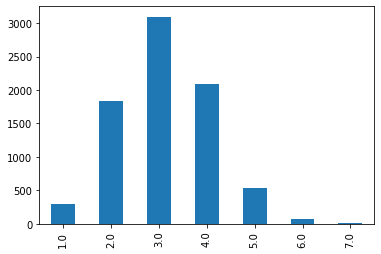

In [28]:
train_X_df.info_bedrooms.value_counts().sort_index().plot(kind='bar')

Do là `bedrooms` và các giá trị của nó là số nguyên, nên nhóm dùng `most` để lắp đầy các giá trị thiếu cho cột `info_bedrooms`

2. Xem thử cột `info_bathrooms` có bao nhiêu giá trị thiếu và chọn cách để lắp đầy các giá trị thiếu đó.

In [29]:
num_miss_bathrooms = train_X_df.shape[0] - len(train_X_df[pd.notnull(train_X_df.info_bathrooms)])
print("The number of missing values (column 'info_bathrooms'): " + str(num_miss_bathrooms))

The number of missing values (column 'info_bathrooms'): 807


Cột `info_bathrooms` có `807` giá trị bị thiếu.

In [30]:
train_X_df.info_bathrooms.value_counts()

3.0     3200
2.0     3162
1.0      716
4.0      481
5.0      255
6.0      101
7.0       21
8.0        8
9.0        3
1.5        3
2.5        2
3.5        2
11.0       1
5.5        1
Name: info_bathrooms, dtype: int64

In [31]:
train_X_df.info_bathrooms.describe()

count    7956.000000
mean        2.603821
std         0.997120
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        11.000000
Name: info_bathrooms, dtype: float64

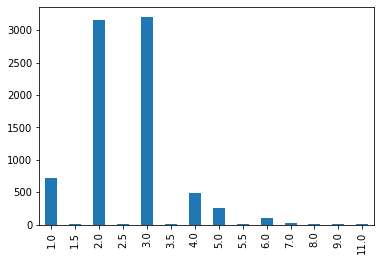

In [32]:
train_X_df.info_bathrooms.value_counts().sort_index().plot(kind='bar')

Tương tự nhóm cùng sẽ dùng `most` để lắp đầy các giá trị thiếu cho cột `info_bathrooms`

### 4.2.6. Quan sát cột `info_size` và cột `info_lot_size`

Đây là cột dạng số (numerical) - float64

1. Xem thử cột `info_size` có bao nhiêu giá trị thiếu và chọn cách để lắp đầy các giá trị thiếu đó.

In [33]:
num_miss_size= train_X_df.shape[0] - len(train_X_df[pd.notnull(train_X_df.info_size)])
print("The number of missing values (column 'info_size'): " + str(num_miss_size))

The number of missing values (column 'info_size'): 402


Cột `info_size` có `402` giá trị bị thiếu.

In [34]:
train_X_df.info_size.value_counts()

1190.0      22
1240.0      22
1472.0      22
1009.0      19
1270.0      17
1072.0      16
1032.0      16
1560.0      16
1460.0      15
1250.0      15
1680.0      15
1079.0      15
1200.0      14
1388.0      14
1574.0      14
1320.0      14
1526.0      13
989.0       13
1440.0      13
1626.0      13
1307.0      13
1056.0      13
1199.0      13
1538.0      12
1325.0      12
1232.0      12
1480.0      12
1110.0      12
1342.0      12
1204.0      12
            ..
4412.0       1
1809.0       1
3499.0       1
7375.0       1
4273.0       1
610.0        1
1405.0       1
3029.0       1
3546.0       1
3129.0       1
911.0        1
2884.0       1
1811.0       1
4399.0       1
633.0        1
2758.0       1
2871.0       1
3621.0       1
4964.0       1
3580.0       1
4508.0       1
755.0        1
2353.0       1
4259.0       1
148976.0     1
13002.0      1
4207.0       1
2887.0       1
3451.0       1
2845.0       1
Name: info_size, Length: 2956, dtype: int64

In [35]:
train_X_df.info_size.describe()

count      8361.000000
mean       2441.498625
std        7309.051184
min         301.000000
25%        1265.000000
50%        1678.000000
75%        2381.000000
max      339999.000000
Name: info_size, dtype: float64

In [36]:
len(train_X_df.info_size.unique())

2957

Điền các giá trị thiếu bằng `mean`.

2. Xem thử cột `info_lot_size` có bao nhiêu giá trị thiếu và chọn cách để lắp đầy các giá trị thiếu đó.

In [37]:
num_miss_lot_size= train_X_df.shape[0] - len(train_X_df[pd.notnull(train_X_df.info_lot_size)])
print("The number of missing values (column 'info_size'): " + str(num_miss_lot_size))

The number of missing values (column 'info_size'): 2832


Cột `info_size` có `2832` giá trị bị thiếu.

In [38]:
train_X_df.info_lot_size.value_counts()

6000.00     303
7200.00     101
5000.00      81
7000.00      76
6600.00      57
4000.00      51
6300.00      44
4500.00      42
6500.00      41
7500.00      39
8400.00      31
7800.00      30
5200.00      29
6100.00      29
3600.00      29
5500.00      28
3478.00      27
7700.00      23
8000.00      23
6200.00      23
6120.00      22
8800.00      21
10000.00     20
9000.00      20
5400.00      19
6240.00      19
7560.00      18
3000.00      18
6250.00      18
6060.00      18
           ... 
21032.00      1
3943.00       1
1.70          1
5763.00       1
8855.00       1
7534.00       1
4812.00       1
2992.00       1
3984.00       1
3012.00       1
10425.00      1
630.00        1
5593.00       1
4946.00       1
0.62          1
11670.00      1
19214.00      1
19250.00      1
3525.00       1
4780.00       1
7539.00       1
7997.00       1
6959.00       1
3868.00       1
8208.00       1
11465.00      1
3469.00       1
3465.00       1
10285.00      1
11376.00      1
Name: info_lot_size, Len

In [39]:
train_X_df.info_lot_size.describe()

count     5931.00000
mean      6475.06449
std       3663.59606
min          0.50000
25%       4400.00000
50%       6240.00000
75%       7806.00000
max      21750.00000
Name: info_lot_size, dtype: float64

In [40]:
len(train_X_df.info_lot_size.unique())

2622

Điền các giá trị thiếu bằng `mean`.

### 4.2.7. Quan sát cột `info_year_built`

Đây là cột dạng số (numerical) - float64

Xem thử cột `info_year_built` có bao nhiêu giá trị thiếu

In [41]:
num_miss_year_built = train_X_df.shape[0] - len(train_X_df[pd.notnull(train_X_df.info_year_built)])
print("The number of missing values (column 'info_size'): " + str(num_miss_year_built))

The number of missing values (column 'info_size'): 664


Cột `info_year_built` có `664` giá trị bị thiếu.

In [42]:
train_X_df.info_year_built.value_counts()

1964.0    252
1989.0    250
1963.0    225
1972.0    216
1977.0    210
1973.0    205
1965.0    202
1976.0    199
1990.0    197
1955.0    196
1974.0    196
1971.0    186
1986.0    176
1969.0    172
1980.0    169
1978.0    166
1979.0    165
1983.0    162
1987.0    161
1962.0    161
1956.0    158
1984.0    147
1954.0    144
1959.0    144
1985.0    142
1975.0    138
1968.0    127
1960.0    122
2003.0    119
1981.0    116
         ... 
1937.0      8
1940.0      7
1936.0      7
1921.0      7
1926.0      7
1941.0      6
1939.0      5
1931.0      4
1944.0      4
1915.0      4
1914.0      4
1942.0      4
1932.0      3
1912.0      3
1910.0      3
1933.0      3
1908.0      2
1916.0      2
1917.0      2
1907.0      2
1904.0      2
1934.0      2
1894.0      1
1919.0      1
1943.0      1
1900.0      1
1911.0      1
1918.0      1
1899.0      1
1913.0      1
Name: info_year_built, Length: 111, dtype: int64

In [43]:
train_X_df.info_year_built.describe()

count    8099.000000
mean     1976.009137
std        17.817193
min      1894.000000
25%      1964.000000
50%      1976.000000
75%      1989.000000
max      2014.000000
Name: info_year_built, dtype: float64

In [44]:
len(train_X_df.info_year_built.unique())

112

### 4.2.8. Quan sát các cột `info_property_id`, `info_county` và `info_parcel_number`

- `info_property_id` là cột dạng số (numerical) - int64
- `info_county` là cột dạng chuỗi có giá trị rời rạc không thứ tự (categorical)
- `info_parcel_number` là cột dạng số (numerical) - int64

Bỏ đi các cột này, vì 2 cột `info_property_id` và `info_parcel_number` ứng với mỗi dòng dữ liệu là hoàn toàn khác nhau; còn cột `info_county` thì có giá trị là `Orange County` (do dữ liệu thu thập của Quận Cam).

### 4.2.9. Quan sát các cột `taxes_land`, `taxes_improvements`, `taxes_total` và `taxes_taxes`

Các cột này đều là cột dạng số (numerical) - float64

In [46]:
num_miss_taxes = train_X_df.shape[0] - len(train_X_df[pd.notnull(train_X_df.taxes_land)])
print("The number of missing values (column 'taxes'): " + str(num_miss_taxes))

The number of missing values (column 'taxes'): 131


Có `131` giá trị thiếu cho mỗi cột `taxes_land`, `taxes_improvements`, `taxes_total` và `taxes_taxes`

Search cùng `address_code` thì lắp đầy các giá trị thiếu bằng `mean` của các `taxes` trong cùng `address_code`

Giữ nguyên các cột `taxes_land`, `taxes_improvements` và bỏ cột `taxes_total`. Giải thích thêm ý nghĩa của các cột này:
- Cột `taxes_land` là tiền cải thuế cải tạo đất mà mình phải đóng cho chính phủ.
- Cột `taxes_improvements` là tiền mà mình phải trả do sử dụng các tiện ích của chính phủ (cắt cỏ, tiền rác, củng cố hàng rào,...)
- Cột `taxes_total` là tổng của 2 cột trên.

Đối với cột `taxes_taxes` thì nhóm sẽ rút trích số tiền phải trả trong cột này ra.

In [47]:
train_X_df.taxes_taxes

10747    10469 (1.15 %)
12214     2195 (1.35 %)
5916      6054 (2.41 %)
489       3663 (0.99 %)
12257     7627 (1.24 %)
5010      5982 (1.17 %)
2271     13419 (1.46 %)
11574     7476 (1.71 %)
6780      2285 (1.32 %)
12148     5296 (1.00 %)
6472      5675 (1.28 %)
2560     14482 (1.13 %)
6759      8013 (1.19 %)
7948      5172 (1.28 %)
263       1147 (1.77 %)
7105      5058 (1.15 %)
5013      3755 (1.04 %)
658       5327 (1.17 %)
1462      7336 (1.14 %)
771       1648 (0.98 %)
6403      7648 (1.01 %)
2002      3802 (1.15 %)
9628      3400 (1.20 %)
4749      8127 (1.10 %)
8001      8820 (1.15 %)
3125      5373 (1.13 %)
10326     4916 (1.18 %)
12278     5487 (1.52 %)
8851      5313 (1.18 %)
3200      9436 (1.13 %)
              ...      
7599     12781 (1.20 %)
1871      8475 (1.40 %)
2046      7404 (1.18 %)
7877      2444 (0.47 %)
4851      6522 (1.12 %)
5072      6766 (1.01 %)
2163      7059 (1.28 %)
6036      8670 (1.14 %)
6921     39133 (1.22 %)
6216      1090 (1.45 %)
11085    11056 (

In [48]:
train_X_df.taxes_taxes.str.extract(r'(\d+)')[0]

10747    10469
12214     2195
5916      6054
489       3663
12257     7627
5010      5982
2271     13419
11574     7476
6780      2285
12148     5296
6472      5675
2560     14482
6759      8013
7948      5172
263       1147
7105      5058
5013      3755
658       5327
1462      7336
771       1648
6403      7648
2002      3802
9628      3400
4749      8127
8001      8820
3125      5373
10326     4916
12278     5487
8851      5313
3200      9436
         ...  
7599     12781
1871      8475
2046      7404
7877      2444
4851      6522
5072      6766
2163      7059
6036      8670
6921     39133
6216      1090
11085    11056
537       1961
9893     11812
2897      3745
7768      5941
2222      1034
10327     2217
2599      1341
705       9078
3468     45212
6744      3761
5874      4619
4373      4858
7891      2465
9225      4770
4859      2715
3264      5833
9845      2368
10799    10122
2732      5806
Name: 0, Length: 8763, dtype: object

### 4.2.10. Quan sát cột `school` và cột `foreclosures`

Các cột này đều là cột dạng số (numerical) - int64

Hai cột này không có giá trị thiếu, nên được giữ nguyên để huấn luyện.

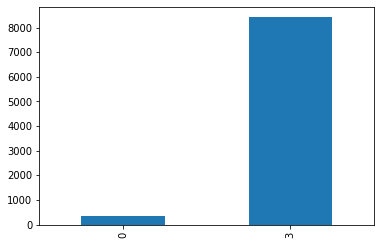

In [49]:
train_X_df.school.value_counts().sort_index().plot(kind='bar')

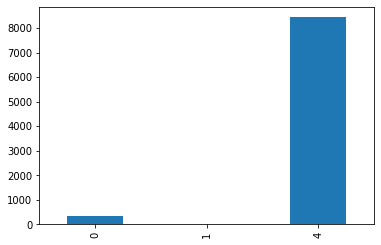

In [50]:
train_X_df.foreclosures.value_counts().sort_index().plot(kind='bar')

### 4.2.11. Quan sát cột `total_crime`, `violent_crime` và `property_crime`

Các cột này đều là cột dạng số (numerical) - float64

Giải thích về ý nghĩa của các cột này. Giá trị mà các cột `total_crime`, `violent_crime` và `property_crime` biểu diễn được tính theo % so với tỉ lệ tội phạm quốc gia. Ví dụ `total_crime = 79` thì ở đây tổng số tội phạm là `79%` so với toàn nước (`100%`).

In [51]:
num_miss_crime = train_X_df.shape[0] - len(train_X_df[pd.notnull(train_X_df.total_crime)])
print("The number of missing values (column 'taxes'): " + str(num_miss_crime))

The number of missing values (column 'taxes'): 265


Có `265` giá trị thiếu cho mỗi cột `total_crime`, `violent_crime` và `property_crime`

In [52]:
train_X_df.total_crime.value_counts()

29.0     952
30.0     800
88.0     713
55.0     707
57.0     582
128.0    504
65.0     381
13.0     350
49.0     329
76.0     313
22.0     292
28.0     274
94.0     264
66.0     234
39.0     184
71.0     178
16.0     173
33.0     144
86.0     137
97.0     135
44.0     127
41.0     126
69.0     122
31.0     115
14.0     107
42.0      83
81.0      63
56.0      61
35.0      28
21.0      20
Name: total_crime, dtype: int64

Search cùng `address_code` thì lắp đầy các giá trị thiếu bằng `median` của các `crime` trong cùng `address_code`

### 4.2.12. Quan sát `correct input` (`sold_price` của ` train_y_sr`)

Đây là cột dạng số (numerical) - float64

In [53]:
train_y_sr.describe()

count    8.763000e+03
mean     1.796080e+06
std      1.422458e+07
min      5.000000e+02
25%      5.620000e+05
50%      7.400000e+05
75%      1.015000e+06
max      4.575680e+08
Name: sold_price, dtype: float64

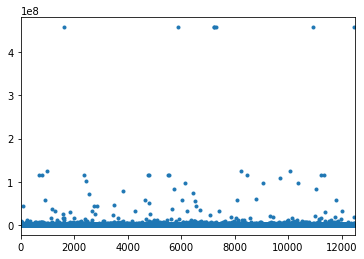

In [54]:
train_y_sr.sort_values().sort_index().plot(style='.')

## 4.3. Thiết kế pipeline tiền xử lý dữ liệu

1. Cột `address_street`: 
    - Ở đây có 4 thông tin được rút trích (xem  phần `4.2.1. Quan sát cột address_street` ở trên):
         + `number`: số nhà, thông tin này không cần thiết cho việc huấn luyện.
         + `direction`: hướng (đông, tây, nam, bắc) của đường, thông tin này không cần thiết cho việc huấn luyện.
         + `street`: tên đường, theo kết quả parse thì thu được đến 6051 tên đường lớn/nhỏ khác nhau. Nếu đưa tên đường này vào huấn luyện thì có 3 vấn đề: thứ nhất là nếu dùng one-hot để chuyển sang dạng số thì sẽ làm tăng số chiều dữ liệu lên rất nhiều (thêm đến trên 6000 thuộc tính), thứ hai do có khoảng 1500 tên đường chỉ xuất hiện duy nhất một lần trong `train_X_df`, còn các tên đường khác thì cũng có tần số xuất hiện khá thấp (cao nhất chỉ có 16 lần) nên nếu thêm vào huấn luyện có thể dẫn đến overfitting, thứ 3 là nếu như ở tập `validation` hay tập `test` mà có tên đường không nằm trong tập `train` thì cũng khó khăn để giải quyết. Nên nhóm quyết định không lấy thông tin `street` để huấn luyện.
         + `apt_unit`: cho biết căn nhà có thuộc chung cư nào hay không, thông tin này nhóm nghĩ là cần thiết cho việc huấn luyện vì nghĩ giá nhà riêng sẽ có phần nào khác với các căn nhà thuộc các khu chung cư. Vì vậy, sẽ thêm cột `apt_unit` vào để huấn luyện, cột này chỉ có 2 giá trị `0`/`1` (nếu thuộc chung cư thì `1`, ngược lại thì `0`).
    - Tóm lại, các việc cần làm:
        + Rút trích ra cột `apt_unit` (như mô tả ở trên) và thêm vào dữ liệu.
        + Xóa cột `address_street`.
        + Lắp đầy giá trị thiếu bằng KNN (n=5) trong cùng một phạm vi (cùng mã `address_code`).
        + Đây là dữ liệu số, để nguyên vậy vào huấn luyện.
         
2. Xóa 2 cột `address_locality` và cột `address_region`, giữ lại cột `address_code` (lý do xem ở phần `4.2.2. Quan sát các cột address_locality, address_region và address_code` ở trên). Ở tập `train_X_df` thì không thấy dữ liệu thiếu, nếu thiếu dùng KNN (n=5) để lấp đầy. Đưa vào tập train huấn luyện thì xem tại link (https://towardsdatascience.com/transforming-categorical-information-into-usable-measures-in-a-machine-learning-model-e2910bbb3fc7).
3. Cột `date_sold`: rút trích `month` ra (xem ở phần `4.2.3. Quan sát cột date_sold`), xóa cột `date_sold` thêm vào cột `month`. Ở tập `train_X_df` thì không thấy dữ liệu thiếu, nếu thiếu dùng KNN(n=5) để lấp đầy. Bỏ vào huấn luyện dùng one-hot, nhớ là thử để nguyên `11` tháng huấn luyện tốt hơn hay chia ra thành `4` mùa tốt hơn bằng cách đặt thêm cờ hiệu `month_to_seasion`.
4. Cột `mortgage`: để nguyên. Ở tập `train_X_df` thì không thấy dữ liệu thiếu, nếu thiếu dùng KNN (n=5) để lấp đầy. Dạng số, cứ bỏ thẳng vào huấn luyện.
5. Cột `info_type`: Có một số giá trị xuất hiện rất ít, nhóm thử dùng thêm tham số `num_top_type` để chọn ra các `info_type` xuất hiện nhiều lần; còn các giá trị nằm ngoài `num_top_type` nhóm sẽ cho là giá trị `Others`. (như `BT03-TienXuLy_ChongOverfit`). Ở tập `train_X_df` thì không thấy dữ liệu thiếu, nếu thiếu dùng KNN (n=5) để lấp đầy. Đưa vào huấn luyện thì dùng one-hot.
6. Hai cột `info_bedrooms` và `info_bathrooms`: lắp đầy giá trị thiều bằng `most`. Kiểu số, cứ bỏ thẳng vào huấn luyện.
7. Hai cột `info_size` và `info_lot_size`: dùng KNN (n=5) để lắp đầy giá trị thiếu trong cùng khu vực (cùng `address_code`). Kiểu số, cứ bỏ thẳng vào huấn luyện.
8. Xóa 3 cột` info_property_id`, `info_county` và `info_parcel_number` (lý do xem ở phần `4.2.9. Quan sát các cột info_property_id, info_county và info_parcel_number`).
9. Các cột `taxes_land`, `taxes_improvements`, `taxes_total` và `taxes_taxes`: đầu tiên rút trích `taxes` cho cột `taxes_taxes`, thay bằng dữ liệu tìm được (xem ở phần `4.2.10. Quan sát các cột taxes_land, taxes_improvements và taxes_taxes`), nhớ xóa cột `taxes_total`. Điền các giá trị thiếu bằng `mean` trong cùng khu vực (cùng `address_code`). Kiểu số, cứ bỏ thẳng vào huấn luyện.
10. Giữ nguyên cột `school` và cột `foreclosures`. Nếu có giá trị thiếu thì điền bằng `median` trong cùng khu vực (cùng `address_code`). Kiểu số, cứ bỏ thẳng vào huấn luyện.
11. Các `total_crime`, `violent_crime` và `property_crime`: lắp đầy giá trị thiếu bằng `median` trong cùng khu vực (cùng `address_code`). Kiểu số, cứ bỏ thẳng vào huấn luyện.

- Chuẩn hóa theo cách của thầy trong `BT03`.
- Dùng mô hình `Linear Regression` để huấn luyện mô mình thử xem.